In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from colour import Color
from scipy.optimize import linear_sum_assignment

/var/folders/l2/kwxvbnds5n5bq9tl0g4kr8zc0000gn/T/ipykernel_20739/4041591044.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from collections import defaultdict

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [42]:
def modified_sankey(left, right, Best_matchs, leftWeight=None, rightWeight=None, colorDict=None,
           leftLabels=None, rightLabels=None, aspect=4, rightColor=False,
           fontsize=14, figureName=None, closePlot=False):
    '''
    Make Sankey Diagram showing flow from left-->right

    Inputs:
        left = NumPy array of object labels on the left of the diagram
        right = NumPy array of corresponding labels on the right of the diagram
            len(right) == len(left)
        leftWeight = NumPy array of weights for each strip starting from the
            left of the diagram, if not specified 1 is assigned
        rightWeight = NumPy array of weights for each strip starting from the
            right of the diagram, if not specified the corresponding leftWeight
            is assigned
        colorDict = Dictionary of colors to use for each label
            {'label':'color'}
        leftLabels = order of the left labels in the diagram
        rightLabels = order of the right labels in the diagram
        aspect = vertical extent of the diagram in units of horizontal extent
        rightColor = If true, each strip in the diagram will be be colored
                    according to its left label
    Ouput:
        None
    '''
    if leftWeight is None:
        leftWeight = []
    if rightWeight is None:
        rightWeight = []
    if leftLabels is None:
        leftLabels = []
    if rightLabels is None:
        rightLabels = []
    # Check weights
    if len(leftWeight) == 0:
        leftWeight = np.ones(len(left))

    if len(rightWeight) == 0:
        rightWeight = leftWeight

    plt.figure()
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')

    # Create Dataframe
    if isinstance(left, pd.Series):
        left = left.reset_index(drop=True)
    if isinstance(right, pd.Series):
        right = right.reset_index(drop=True)
    dataFrame = pd.DataFrame({'left': left, 'right': right, 'leftWeight': leftWeight,
                              'rightWeight': rightWeight}, index=range(len(left)))

    if len(dataFrame[(dataFrame.left.isnull()) | (dataFrame.right.isnull())]):
        raise NullsInFrame('Sankey graph does not support null values.')

    # Identify all labels that appear 'left' or 'right'
    allLabels = pd.Series(np.r_[dataFrame.left.unique(), dataFrame.right.unique()]).unique()

    # Identify left labels
    if len(leftLabels) == 0:
        leftLabels = pd.Series(dataFrame.left.unique()).unique()
    else:
        #check_data_matches_labels(leftLabels, dataFrame['left'], 'left')
        None

    # Identify right labels
    if len(rightLabels) == 0:
        rightLabels = pd.Series(dataFrame.right.unique()).unique()
    else:
        None
        #check_data_matches_labels(leftLabels, dataFrame['right'], 'right')
    # If no colorDict given, make one
    if colorDict is None:
        colorDict = {}
        palette = "hls"
        colorPalette = sns.color_palette(palette, len(allLabels))
        for i, label in enumerate(allLabels):
            colorDict[label] = colorPalette[i]
    else:
        missing = [label for label in allLabels if label not in colorDict.keys()]
        if missing:
            msg = "The colorDict parameter is missing values for the following labels : "
            msg += '{}'.format(', '.join(missing))
            raise ValueError(msg)

    # Determine widths of individual strips
    ns_l = defaultdict()
    ns_r = defaultdict()
    for leftLabel in leftLabels:
        leftDict = {}
        rightDict = {}
        for rightLabel in rightLabels:
            leftDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].leftWeight.sum()
            rightDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].rightWeight.sum()
        ns_l[leftLabel] = leftDict
        ns_r[leftLabel] = rightDict

    # Determine positions of left label patches and total widths
    leftWidths = defaultdict()
    for i, leftLabel in enumerate(leftLabels):
        myD = {}
        myD['left'] = dataFrame[dataFrame.left == leftLabel].leftWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['left']
        else:
            myD['bottom'] = leftWidths[leftLabels[i - 1]]['top'] + 0.02 * dataFrame.leftWeight.sum()
            myD['top'] = myD['bottom'] + myD['left']
            topEdge = myD['top']
        leftWidths[leftLabel] = myD

    # Determine positions of right label patches and total widths
    rightWidths = defaultdict()
    for i, rightLabel in enumerate(rightLabels):
        myD = {}
        myD['right'] = dataFrame[dataFrame.right == rightLabel].rightWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['right']
        else:
            myD['bottom'] = rightWidths[rightLabels[i - 1]]['top'] + 0.02 * dataFrame.rightWeight.sum()
            myD['top'] = myD['bottom'] + myD['right']
            topEdge = myD['top']
        rightWidths[rightLabel] = myD

    # Total vertical extent of diagram
    xMax = topEdge / aspect

    # Draw vertical bars on left and right of each  label's section & print label
    for leftLabel in leftLabels:
        plt.fill_between(
            [-0.02 * xMax, 0],
            2 * [leftWidths[leftLabel]['bottom']],
            2 * [leftWidths[leftLabel]['bottom'] + leftWidths[leftLabel]['left']],
            color=colorDict[leftLabel],
            alpha=0.99
        )
        plt.text(
            -0.05 * xMax,
            leftWidths[leftLabel]['bottom'] + 0.5 * leftWidths[leftLabel]['left'],
            leftLabel,
            {'ha': 'right', 'va': 'center'},
            fontsize=fontsize
        )
    for rightLabel in rightLabels:
        plt.fill_between(
            [xMax, 1.02 * xMax], 2 * [rightWidths[rightLabel]['bottom']],
            2 * [rightWidths[rightLabel]['bottom'] + rightWidths[rightLabel]['right']],
            color=colorDict[rightLabel],
            alpha=0.99
        )
        plt.text(
            1.05 * xMax,
            rightWidths[rightLabel]['bottom'] + 0.5 * rightWidths[rightLabel]['right'],
            rightLabel,
            {'ha': 'left', 'va': 'center'},
            fontsize=fontsize
        )

    # Plot strips
    for leftLabel in leftLabels:
        for rightLabel in rightLabels:
            labelColor = leftLabel
            if rightColor:
                labelColor = rightLabel
            if len(dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)]) > 0:
                # Create array of y values for each strip, half at left value,
                # half at right, convolve
                ys_d = np.array(50 * [leftWidths[leftLabel]['bottom']] + 50 * [rightWidths[rightLabel]['bottom']])
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_u = np.array(50 * [leftWidths[leftLabel]['bottom'] + ns_l[leftLabel][rightLabel]] + 50 * [rightWidths[rightLabel]['bottom'] + ns_r[leftLabel][rightLabel]])
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')

                # Update bottom edges at each label so next strip starts at the right place
                leftWidths[leftLabel]['bottom'] += ns_l[leftLabel][rightLabel]
                rightWidths[rightLabel]['bottom'] += ns_r[leftLabel][rightLabel]
                if Best_matchs[leftLabel] == rightLabel:
                    stripe_color = colorDict[rightLabel]
                else:
                    stripe_color = Color("lightgrey").hex_l
                plt.fill_between(
                    np.linspace(0, xMax, len(ys_d)), ys_d, ys_u, alpha=0.65,
                    #color=colorDict[labelColor]
                    color = stripe_color
                )
    plt.gca().axis('off')
    plt.gcf().set_size_inches(6, 6)
    if figureName != None:
        plt.savefig("{}.png".format(figureName), bbox_inches='tight', dpi=150)
    if closePlot:
        plt.close()

In [4]:
raw = pd.read_csv("SankeyData_KMT.csv", sep = ",")
raw = pd.DataFrame(raw.sort_values(by = ["Human Symbol","Score"], ascending=False).to_numpy(), 
                   index=raw.index, columns=raw.columns)
raw["Left"] = raw["Score"]/raw.groupby("Human Symbol")["Score"].transform('sum')

In [35]:
leftorders = pd.Series(raw['Human Symbol'].unique()).unique()
rightorders = pd.Series(raw['T. castaneum Gene'].unique()).unique()
Score_matrix = np.zeros((len(leftorders),len(rightorders)))
for i,left in enumerate(leftorders):
    sub_data = raw[raw['Human Symbol'] == left]
    for j,right in enumerate(rightorders):
        try:
            score = sub_data[sub_data['T. castaneum Gene'] == right].Score.tolist()[0]
            Score_matrix[(i,j)] = score
        except:
            None
row_indices, col_indices = linear_sum_assignment(-Score_matrix)
new_rightorders = [rightorders[i] for i in col_indices]
#Add missed genes
for i in [i for i in rightorders if i not in new_rightorders]:
    index = np.where(rightorders == i)[0][0]
    insert_pos = np.argmax(Score_matrix[:,index])
    new_rightorders = np.insert(new_rightorders, insert_pos, i)


In [43]:
colordic = {}
human_ids = raw["Human Symbol"].unique()
Tc_ids = raw["T. castaneum Gene"].unique()
n  = len(human_ids)
startcolor = Color("blue")
color = list(startcolor.range_to(Color("#4aeef2"),n))
Best_matchs = {}
for i,ID in zip(range(n),human_ids):
    colordic[ID] = color[i].hex_l
    top_match_Tc = raw[raw['Human Symbol'] == ID]['T. castaneum Gene'].tolist()[0]
    Best_matchs[ID] = top_match_Tc
    colordic[top_match_Tc] = color[i].hex_l
for i in Tc_ids:
    if i not in colordic.keys():
        colordic[i] = Color("lightgrey").hex_l


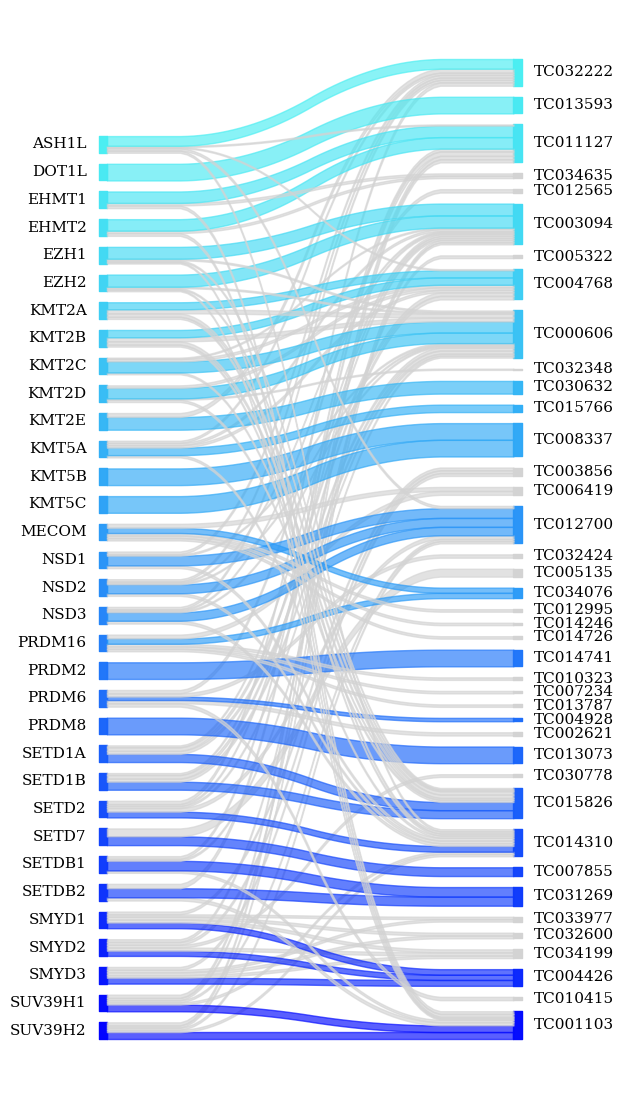

In [44]:
modified_sankey(raw["Human Symbol"], raw["T. castaneum Gene"],Best_matchs,rightLabels=new_rightorders,
       leftWeight= raw["Left"], rightWeight = raw["Left"], colorDict=colordic,
      aspect=20, fontsize=11, figureName = 'Test')
fig = plt.gcf()
fig.set_size_inches(6, 14)
fig.set_facecolor("w")
fig.savefig("KMT_113024.pdf", bbox_inches="tight", dpi=300)

In [45]:
raw = pd.read_csv("SankeyData_PRMT.csv", sep = ",")
raw = pd.DataFrame(raw.sort_values(by = ["Human Symbol","Score"], ascending=False).to_numpy(), 
                   index=raw.index, columns=raw.columns)
raw["Left"] = raw["Score"]/raw.groupby("Human Symbol")["Score"].transform('sum')

In [46]:
leftorders = pd.Series(raw['Human Symbol'].unique()).unique()
rightorders = pd.Series(raw['T. castaneum Gene'].unique()).unique()
Score_matrix = np.zeros((len(leftorders),len(rightorders)))
for i,left in enumerate(leftorders):
    sub_data = raw[raw['Human Symbol'] == left]
    for j,right in enumerate(rightorders):
        try:
            score = sub_data[sub_data['T. castaneum Gene'] == right].Score.tolist()[0]
            Score_matrix[(i,j)] = score
        except:
            None
row_indices, col_indices = linear_sum_assignment(-Score_matrix)
new_rightorders = [rightorders[i] for i in col_indices]
#Add missed genes
for i in [i for i in rightorders if i not in new_rightorders]:
    index = np.where(rightorders == i)[0][0]
    insert_pos = np.argmax(Score_matrix[:,index])
    new_rightorders = np.insert(new_rightorders, insert_pos, i)

In [47]:
colordic = {}
human_ids = raw["Human Symbol"].unique()
Tc_ids = raw["T. castaneum Gene"].unique()
n  = len(human_ids)
startcolor = Color("#FF6103")
color = list(startcolor.range_to(Color("gold"),n))
Best_matchs = {}
for i,ID in zip(range(n),human_ids):
    colordic[ID] = color[i].hex_l
    top_match_Tc = raw[raw['Human Symbol'] == ID]['T. castaneum Gene'].tolist()[0]
    Best_matchs[ID] = top_match_Tc
    colordic[top_match_Tc] = color[i].hex_l
for i in Tc_ids:
    if i not in colordic.keys():
        colordic[i] = Color("lightgrey").hex_l


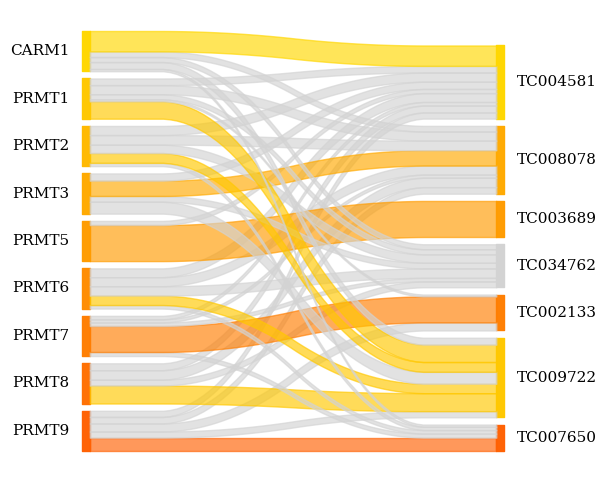

In [49]:
modified_sankey(raw["Human Symbol"], raw["T. castaneum Gene"],Best_matchs,rightLabels=new_rightorders,
       leftWeight= raw["Left"], rightWeight = raw["Left"], colorDict=colordic,
      aspect=20, fontsize=11, figureName = 'Test')
fig = plt.gcf()
fig.set_size_inches(6, 6)
fig.set_facecolor("w")
fig.savefig("PRMT_113024.pdf", bbox_inches="tight", dpi=300)

In [50]:
raw = pd.read_csv("SankeyData_KDM.csv", sep = ",")
raw = pd.DataFrame(raw.sort_values(by = ["Human Symbol","Score"], ascending=False).to_numpy(), 
                   index=raw.index, columns=raw.columns)
raw["Left"] = raw["Score"]/raw.groupby("Human Symbol")["Score"].transform('sum')

In [51]:
leftorders = pd.Series(raw['Human Symbol'].unique()).unique()
rightorders = pd.Series(raw['T. castaneum Gene'].unique()).unique()
Score_matrix = np.zeros((len(leftorders),len(rightorders)))
for i,left in enumerate(leftorders):
    sub_data = raw[raw['Human Symbol'] == left]
    for j,right in enumerate(rightorders):
        try:
            score = sub_data[sub_data['T. castaneum Gene'] == right].Score.tolist()[0]
            Score_matrix[(i,j)] = score
        except:
            None
row_indices, col_indices = linear_sum_assignment(-Score_matrix)
new_rightorders = [rightorders[i] for i in col_indices]
#Add missed genes
for i in [i for i in rightorders if i not in new_rightorders]:
    index = np.where(rightorders == i)[0][0]
    insert_pos = np.argmax(Score_matrix[:,index])
    new_rightorders = np.insert(new_rightorders, insert_pos, i)

In [52]:
colordic = {}
human_ids = raw["Human Symbol"].unique()
Tc_ids = raw["T. castaneum Gene"].unique()
n  = len(human_ids)
startcolor = Color("darkgreen")
color = list(startcolor.range_to(Color("lightgreen"),n))
Best_matchs = {}
for i,ID in zip(range(n),human_ids):
    colordic[ID] = color[i].hex_l
    top_match_Tc = raw[raw['Human Symbol'] == ID]['T. castaneum Gene'].tolist()[0]
    Best_matchs[ID] = top_match_Tc
    colordic[top_match_Tc] = color[i].hex_l
for i in Tc_ids:
    if i not in colordic.keys():
        colordic[i] = Color("lightgrey").hex_l


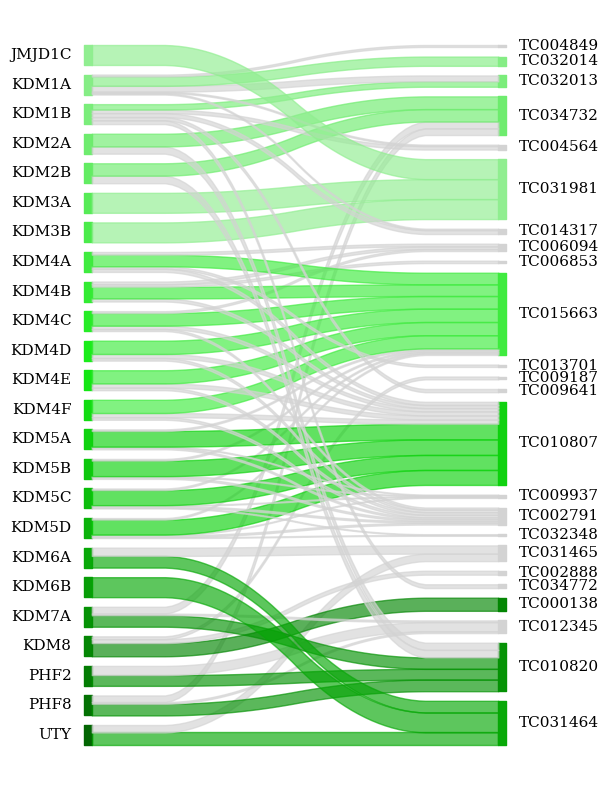

In [53]:
modified_sankey(raw["Human Symbol"], raw["T. castaneum Gene"],Best_matchs,rightLabels=new_rightorders,
       leftWeight= raw["Left"], rightWeight = raw["Left"], colorDict=colordic,
      aspect=20, fontsize=11, figureName = 'Test')
fig = plt.gcf()
fig.set_size_inches(6, 10)
fig.set_facecolor("w")
fig.savefig("KDM_113024.pdf", bbox_inches="tight", dpi=300)